In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd , sys
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import clear_output
from sklearn.metrics import auc , roc_auc_score
from sklearn.model_selection import train_test_split
sys.path.append("/home/advice/Python/SR/Custom/")
from Init import spectral_norm
from RAdam import RAdamOptimizer
import seaborn as sns
import re , os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplot

1.15.0


W0112 21:24:25.390960 140577519961856 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import shutil
try :
    os.makedirs("./NNEnsembleResult/g")
    os.makedirs("./NNEnsembleResult/h")
except Exception as e :
    shutil.rmtree("./NNEnsembleResult/g")
    shutil.rmtree("./NNEnsembleResult/h")
    os.makedirs("./NNEnsembleResult/g")
    os.makedirs("./NNEnsembleResult/h")

In [3]:
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
            
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

In [4]:
data = pd.read_csv("./../Data/bakingsoda_data_creditcard-train-0.5-0.5.csv")
testdata = pd.read_csv("./../Data/bakingsoda_data_creditcard-test-0.5-0.5.csv")
data.isna().sum().sum()

4229710

In [5]:
testdata.isna().sum().sum()

1238077

In [6]:
data = data.dropna(subset=["Class"])
testdata = testdata.dropna(subset=["Class"])
data = data.drop(["sep_idx"], axis = 1)
testdata = testdata.drop(["sep_idx"], axis = 1)

In [7]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,NaN,0.266151,NaN,NaN,0.060018,-0.082361,-0.078803,NaN,-0.255425,-0.166974,...,NaN,-0.638672,NaN,NaN,NaN,NaN,-0.008983,NaN,2.69,0.0
4,1.229658,NaN,NaN,NaN,0.191881,0.272708,-0.005159,NaN,NaN,-0.099254,...,NaN,-0.270710,-0.154104,NaN,NaN,NaN,NaN,NaN,4.99,0.0
5,NaN,0.286157,-0.113192,NaN,NaN,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,NaN,-0.384157,NaN,0.142404,93.20,0.0
8,-2.791855,NaN,1.641750,NaN,-0.136588,0.807596,-0.422911,NaN,NaN,NaN,...,NaN,NaN,1.020586,0.028317,NaN,-0.235557,-0.164778,NaN,58.80,0.0
9,-0.752417,NaN,NaN,NaN,-1.158394,NaN,NaN,NaN,NaN,0.747731,...,0.499625,1.353650,NaN,-0.065084,-0.039124,-0.087086,NaN,0.129394,15.99,0.0


In [8]:

target = data.pop("Class")
testtarget =  testdata.pop("Class")
num_col = data.select_dtypes("float").columns.tolist()

In [9]:
# Trval_X , Test_X , Trval_y , Test_y = train_test_split(onehot_data , target , test_size = 0.3)
# Trval_X.reset_index(drop=True , inplace=True)
# Trval_y.reset_index(drop=True , inplace=True)
Train_X , Test_X , Train_y , Test_y = data , testdata , target , testtarget
#tr_idx = np.array(Train_X.index.tolist())
#va_idx = np.array(Valid_X.index.tolist())

In [10]:
one_hot_var = Train_X.columns.tolist()
in_var = data.columns.tolist()

In [11]:
def spectral_norm(w, iteration=1 , name = None):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    u = tf.get_variable(name , [1, w_shape[-1]], 
                        initializer=tf.random_normal_initializer(), trainable=False)
    u_hat = u
    v_hat = None
    for i in range(iteration):
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)
    return w_norm 

def OneHotIndex(in_var , num_var , one_hot_var) :
    start_idx = 0
    key_store = {}
    store = []
    for idx , col in enumerate(in_var) :
        if col in num_var :
            aa = [start_idx , start_idx +1]
            store.append(aa)
            start_idx += 1
        else :
            find = [idx for idx , ck in enumerate(one_hot_var) if re.search("^{}_".format(col) , ck)]
            nn = len(find)
            aa = [start_idx , start_idx + nn]
            start_idx += nn
            store.append(aa)
        key_store[col] = aa
    return key_store , store

In [12]:
key_onehot_store , onehot_store = OneHotIndex(in_var , num_col , one_hot_var)

In [13]:
Train_y.reset_index(drop=True ,inplace=True)
target_1_list = Train_y[(Train_y == 1) == True].index.tolist()
target_0_list = Train_y[(Train_y == 0) == True].index.tolist()

In [14]:
ck = list(set(target_1_list) & set(target_0_list))
assert ck == [], "중복 발생 : {}".format(ck)

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler

numeric_features = num_col 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler(feature_range=(-1,1)))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),])

In [16]:
clf.fit(Train_X)
Train_X[num_col] = clf.transform(Train_X)
#Valid_X[num_col] = clf.transform(Valid_X)
Test_X[num_col] = clf.transform(Test_X)

## 앙상블 테스트

In [17]:
Train_X_np = Train_X.values
#Valid_X_np = Valid_X.values
Test_X_np = Test_X.values

In [18]:
def tf_mish(x, name="mish") :
    act = x * tf.nn.tanh(tf.nn.softplus(x))
    act = tf.identity(act , name)
    return act

In [19]:
row , dim = Train_X_np.shape
print(row,dim)
target_n = 2 
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [ None , dim])
y = tf.placeholder(tf.float32, shape = [ None , 1])
DropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
training = tf.placeholder_with_default(False, shape=[], name="training")

185078 29


In [20]:
print(in_var)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [21]:
def variable_select(in_var = None , method = None , select_n = None , NTree = None) :
    var_n = len(in_var)
    if method== "sqrt" :
        value =np.sqrt(var_n)
    elif method == "log2" :
        value =np.log2(var_n)
    elif method == "select" :
        value = select_n
    else :
        value = var_n
    return [list(np.random.choice(in_var ,
                                  replace = False , 
                                  size = value)) for _ in range(NTree)]
select_var = variable_select(in_var=in_var , method="select" , 
                               select_n= 10 , NTree= 5)

In [22]:
print(select_var)

[['V17', 'V27', 'V11', 'V16', 'V26', 'V20', 'V14', 'V15', 'V6', 'V1'], ['V4', 'V2', 'V11', 'V6', 'V7', 'V17', 'V25', 'V20', 'V23', 'V12'], ['V19', 'V15', 'V3', 'V9', 'V22', 'V8', 'V23', 'V10', 'V12', 'V17'], ['V16', 'V19', 'V2', 'V21', 'V27', 'V8', 'Amount', 'V14', 'V6', 'V26'], ['V20', 'V5', 'V10', 'V15', 'V26', 'V12', 'V16', 'V1', 'V9', 'Amount']]


In [23]:
# var = select_var[0]
# x_input = []
# for key in var :
#     start_node , terminal_node = key_onehot_store[key]
#     diff = terminal_node - start_node
#     X_Split = tf.slice(X , [0, start_node] , [-1 , diff])
#     x_input.append(X_Split)  

## NA -> 1.5 (outlier로 표시하기)

In [ ]:
def Classifier_V2(X , hidden = [[],[]], Nensemble = select_var ) :
    X = tf.where( tf.math.is_nan(X) , tf.ones_like(X) * 1.5 , X)
    Ensembles = []
    with tf.variable_scope("Ensembles"):
        for idx , __vars__ in enumerate(Nensemble) :
            x_input = []
            for key in __vars__ :
                start_node , terminal_node = key_onehot_store[key]
                diff = terminal_node - start_node
                X_Split = tf.slice(X , [0, start_node] , [-1 , diff])
                if diff > 4 : 
                    embeddings = tf.Variable(tf.truncated_normal([diff, int(diff/2)], 
                                                         stddev = 2/diff ))       
                    X_Split = tf.argmax(X_Split , axis = 1)
                    X_Split = tf.nn.embedding_lookup(embeddings, X_Split)
                x_input.append(X_Split)
            x_input = tf.concat(x_input , axis = 1)
            #x_input = tf.layers.batch_normalization(x_input , training=training)
            TOTAL_DIM = x_input.get_shape().as_list()[1]
            SELECT = np.random.randint(0 , len(activate_candidate) , 1)[0]
            activation = activate_candidate[SELECT]
            dims = hidden[idx]
            dims = [TOTAL_DIM] + dims
            print(dims)
            for idx2 , h_dim in enumerate(dims) :
                if idx2 == 0 :
                    Weight =get_weight_variable(shape = [TOTAL_DIM , h_dim], 
                                                name="W_{}{}".format(idx , idx2),
                                                type='xavier_normal', regularize=True)
                    snw = spectral_norm(Weight , name = "SN_{}{}".format(idx , idx2))
                    Bias = tf.get_variable("Bias_{}{}".format(idx , idx2),
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    Layer = activation(tf.matmul( x_input , snw) + Bias)
                    Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
                else :
                    Weight =get_weight_variable(shape = [dims[idx2-1] ,h_dim ], 
                                                name="W_{}{}".format(idx , idx2),
                                                type='xavier_normal', regularize=True)
                    if len(dims) == idx2+1 : pass
                    else : Weight = spectral_norm(Weight , name = "SN_{}{}".format(idx , idx2))
                    Bias = tf.get_variable("Bias_{}{}".format(idx , idx2),
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    Layer = tf.matmul( Layer , Weight) + Bias
                    if len(dims) == idx2+1 : 
                        pass
                    else : 
                        Layer = activation(Layer)
                        Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
            Ensembles.append(Layer)
        return Ensembles

In [ ]:
def tf_mish(x) :
    return x * tf.nn.tanh(tf.nn.softplus(x))
activate_candidate = \
[tf.nn.selu, tf_mish , tf.nn.leaky_relu , tf.nn.elu ]

In [ ]:
HIDDEN = [
    [ 50 , 50,  target_n] , 
    [ 80 , 50, target_n] ,
    [ 60 , 50, target_n] ,
    [ 70 , 50, target_n] ,
    [ 40 , 20, target_n]
         ]
NModels = Classifier_V2(X , hidden = HIDDEN , Nensemble= select_var )

W0112 21:24:28.750107 140577519961856 deprecation.py:323] From <ipython-input-24-fb037db58d58>:2: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[10, 50, 50, 2]
[10, 80, 50, 2]
[10, 60, 50, 2]
[10, 70, 50, 2]
[10, 40, 20, 2]


In [ ]:
NModels_MEAN = tf.reduce_mean(NModels , axis = 0)
Probs = tf.nn.softmax(NModels_MEAN)
y_one_hot = tf.one_hot( tf.cast(tf.squeeze(y , axis = 1 ) , tf.int32) , depth=2)

In [ ]:
y_one_hot

<tf.Tensor 'one_hot:0' shape=(?, 2) dtype=float32>

In [ ]:
# tf.InteractiveSession()
# #tf.one_hot(y , depth= 2).shape
# y = Train_y.values.reshape(-1,1)[0:10].tolist()
# tf.one_hot( tf.cast(tf.squeeze(y , axis = 1 ) , tf.int32) , depth=2).eval()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_weight_info = compute_class_weight(class_weight= "balanced" , 
                     classes = np.unique(Train_y),
                     y= np.squeeze(Train_y))
weight = tf.constant([ y_weight_info[1] ] ) # 

## Version1 (Averaging)

In [ ]:
# WCE = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
#                                                logits = NModels_MEAN , 
#                                                pos_weight =  weight)
# Loss = tf.reduce_mean(WCE)

In [ ]:
mod = sys.modules[__name__]
for idx , Model in enumerate(NModels) :
    setattr(mod, 'model_{}_softmax'.format(idx), 
            tf.argmax( tf.nn.softmax(Model) , axis = 1 ))

## Version2 (개별)

In [ ]:
mod = sys.modules[__name__]
Loss = []
Probs = 0
for idx , Model in enumerate(NModels) :
    loss = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
                                                     logits = Model , 
                                                     pos_weight = weight)
    Probs +=tf.nn.softmax(Model)
    Loss.append(loss)
    #Loss += loss
Loss = tf.reduce_mean(Loss)
#Loss /= len(NModels)
Probs = tf.nn.softmax(Probs)

W0112 21:24:30.106624 140577519961856 deprecation.py:506] From <ipython-input-33-06487420356c>:7: calling weighted_cross_entropy_with_logits (from tensorflow.python.ops.nn_impl) with targets is deprecated and will be removed in a future version.
Instructions for updating:
targets is deprecated, use labels instead


## L1 L2 Penalty

In [ ]:
vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Ensembles")

In [ ]:
# L2 = []
# WEIGHTS = []
# import re 
# for v in vars :
#     if re.search('W_' , v.name) :
#         WEIGHTS.append(v)
#         L2.append(tf.nn.l2_loss(v))
# Loss += tf.add_n(L2)  * 0.0001
# l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
# regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, WEIGHTS )
# Loss += regularization_penalty  * 0.0001

In [ ]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    solver = RAdamOptimizer(learning_rate= 1e-4).minimize(Loss )
# var_list = tf.trainable_variables()

In [ ]:
print(Train_X.shape )
print(Train_y.value_counts())

(185078, 29)
0.0    184760
1.0       318
Name: Class, dtype: int64


[[184760      0]
 [   318      0]]
Epoch : 100 , Loss :4.39228, AUC : 59.04
target 1 oversample n :  318


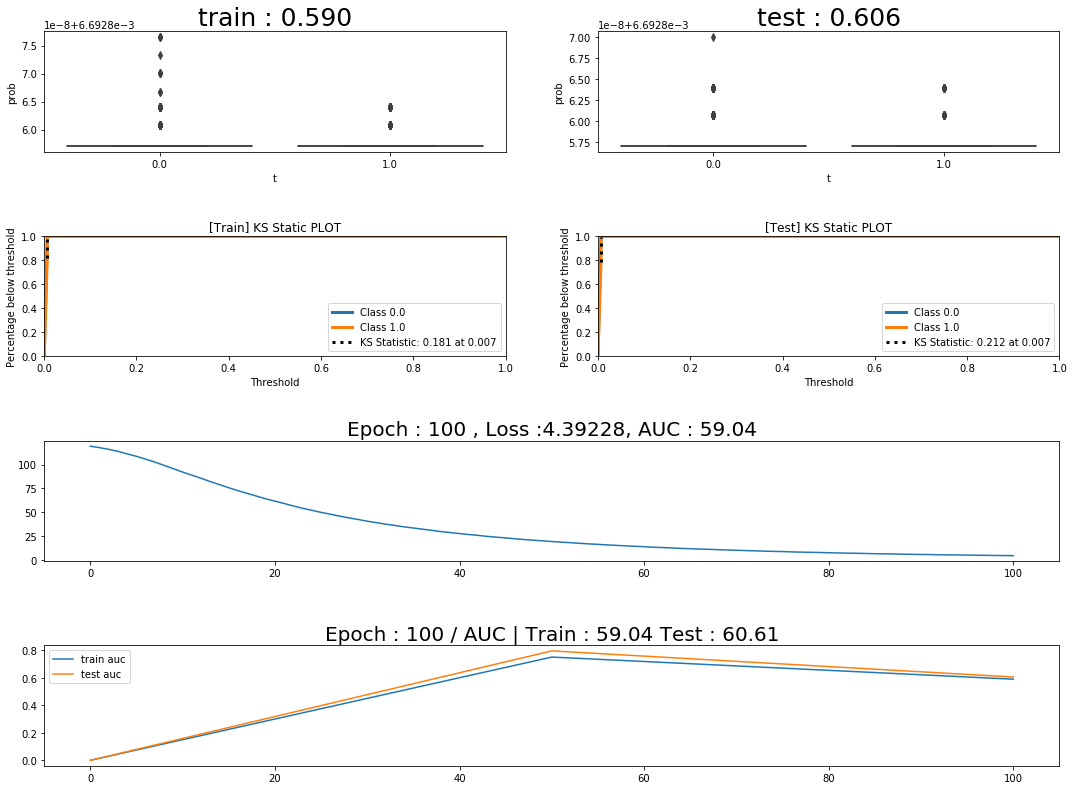

In [ ]:
from sklearn.metrics import confusion_matrix
Epoch = 10000
mb_size = 2000
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
_Loss_ = []
_Epoch_ = []
_Epoch2_ = [0]
_trAUC_ , _teAUC_ = [0] , [0]
print("Train")
for epoch in range(Epoch) :
    print(epoch , end = "\r")
    target1 = np.random.choice(target_1_list ,
                               int(len(target_1_list)/4) ,
                               replace = False )
    target0 = np.random.choice(target_0_list , 
                               len(target_0_list) ,
                               replace = True )
    target1 = list(target1)
    target0 = list(target0)
    if epoch > 10 :
        target1 = target1 + 5 * checkpoint 
    XX = Train_X_np[target1 + target0  , : ]
    YY = Train_y.values[target1 + target0]
    idx = np.random.permutation(len(XX))
    XX = XX[idx , : ]
    YY = YY[idx]
    batch_iter = int(len(XX) / mb_size)
    batchLoss = 0
    for idx in range(batch_iter) :
        X_mb = XX[idx*mb_size:(idx+1)*mb_size]
        Y_mb = YY[idx*mb_size:(idx+1)*mb_size]
        Feed = {X : X_mb ,
                y : Y_mb.reshape(-1,1) , 
                DropoutRate : 0.5 ,
                training : True 
               }
        _ , LOSS  = sess.run([solver , Loss] , feed_dict= Feed)
        batchLoss += LOSS
    batchLoss /= batch_iter
    _Loss_.append(batchLoss)
    _Epoch_.append(epoch)
    
    if epoch % 10 == 0 :
        Feed = { X : Train_X_np  ,
                DropoutRate : 1.0,
                training : False 
               }
        probs  = sess.run(Probs , feed_dict= Feed)
        real_target = np.squeeze(Train_y.values)
        pred_target = np.argmax(probs,axis =1)
        AUC = roc_auc_score(real_target , probs[:,1])
        DD = pd.DataFrame([real_target ,pred_target], index = ["t","p"]).T
        DD2 = DD[(DD.t == 1) & (DD.p==0)]
        checkpoint = DD2.index.tolist()
    
    msg = "Epoch : {} , Loss :{:.5f}, AUC : {:.2f}".format(epoch ,LOSS ,AUC*100)
    if (epoch % 50 == 0) & ( epoch > 0 ) :
#         __idx__ = np.random.permutation(len(Train_X_np))
#         __idx__ = np.random.choice(__idx__ , replace = False, size= 500)
#         Feed = { X : Train_X_np[__idx__,:]  ,
#                 DropoutRate : 1 ,
#                 training : True }
        dd = [sess.run( getattr(mod,  "model_{}_softmax".format(i)) , 
                       feed_dict= Feed)  for i in np.arange(len(NModels))]
        s = pd.DataFrame(dd)
        models = np.arange(s.shape[0])
        indexs = np.arange(s.shape[1])
        fig, ax = plt.subplots( figsize = (12,8))
        plt.pcolor(s)
        plt.yticks(np.arange(0.5, len(models), 1),models)
        plt.title(msg)
        plt.savefig(f"./NNEnsembleResult/g/plot.{epoch:03d}.png")
        plt.close()    
        #d = pd.DataFrame(dd).sum(axis = 0)
        #plt.scatter( np.arange(len(d)) , d.values)
    if (epoch % 50 == 0) & ( epoch > 0 ):
        clear_output()
        print(confusion_matrix(real_target , pred_target))
        print(msg)
        print("target 1 oversample n : ", len(checkpoint))
        trainDD = pd.DataFrame([real_target ,probs[:,1]],
                               index = ["t","prob"]).T
        trainAUC = AUC
        Feed = { X : Test_X_np  ,
            DropoutRate : 1.0 ,
            training : False 
           }
        testprobs  = sess.run(Probs , feed_dict= Feed)
        real_target = np.squeeze(Test_y.values)
        pred_target = np.argmax(testprobs,axis =1)
        testAUC = roc_auc_score(real_target , testprobs[:,1])
        testDD = pd.DataFrame([real_target ,testprobs[:,1]],
                          index = ["t","prob"]).T
        ###################################################
        fig , axes = plt.subplots(nrows=4 ,ncols=2,
                  figsize=(15,12) )
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                            top=0.95, wspace=None, hspace=0.5)
        ax = axes.flatten()
        sns.boxplot(x="t", y="prob", data=trainDD, ax = ax[0])
        ax[0].set_title("train : {:.3f}".format(trainAUC), fontsize= 25)
        sns.boxplot(x="t", y="prob", data=testDD, ax = ax[1])
        ax[1].set_title("test : {:.3f}".format(testAUC), fontsize= 25)
        skplt.metrics.plot_ks_statistic(Train_y.values, probs , 
                                        ax = ax[2] , 
                                        title = "[Train] KS Static PLOT")
        skplt.metrics.plot_ks_statistic(Test_y.values, testprobs ,
                                        ax = ax[3], 
                                        title = "[Test] KS Static PLOT")

        ax3 = plt.subplot(413)
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                            top=0.95, wspace=None, hspace=0.7)
        ax3.plot(_Epoch_ , _Loss_ )
        ax3.set_title(msg, fontsize= 20)
        _Epoch2_.append(epoch)
        _trAUC_.append(trainAUC)
        _teAUC_.append(testAUC)
        ax4 = plt.subplot(414)
        ax4.plot(_Epoch2_ , _trAUC_ , label = "train auc")
        ax4.plot(_Epoch2_ , _teAUC_ , label = "test auc")
        ax4.legend()
        msg = "Epoch : {} / AUC | Train : {:.2f} Test : {:.2f}".format(epoch , 
                                                               100*trainAUC ,
                                                               100*testAUC)
        ax4.set_title(msg, fontsize= 20)
        plt.savefig(f"./NNEnsembleResult/h/plot.{epoch:03d}.png")
        plt.show()

## Batch Normalization
* http://openresearch.ai/t/topic/80
* https://stackoverflow.com/questions/43234667/tf-layers-batch-normalization-large-test-error/43276405#43276405
* https://stackoverflow.com/questions/47199514/using-batch-normalization-with-dropout-in-test-phase-gives-nan

Text(0.5, 1.0, '[178] AUC / Train : 86.78 Test : 89.17')

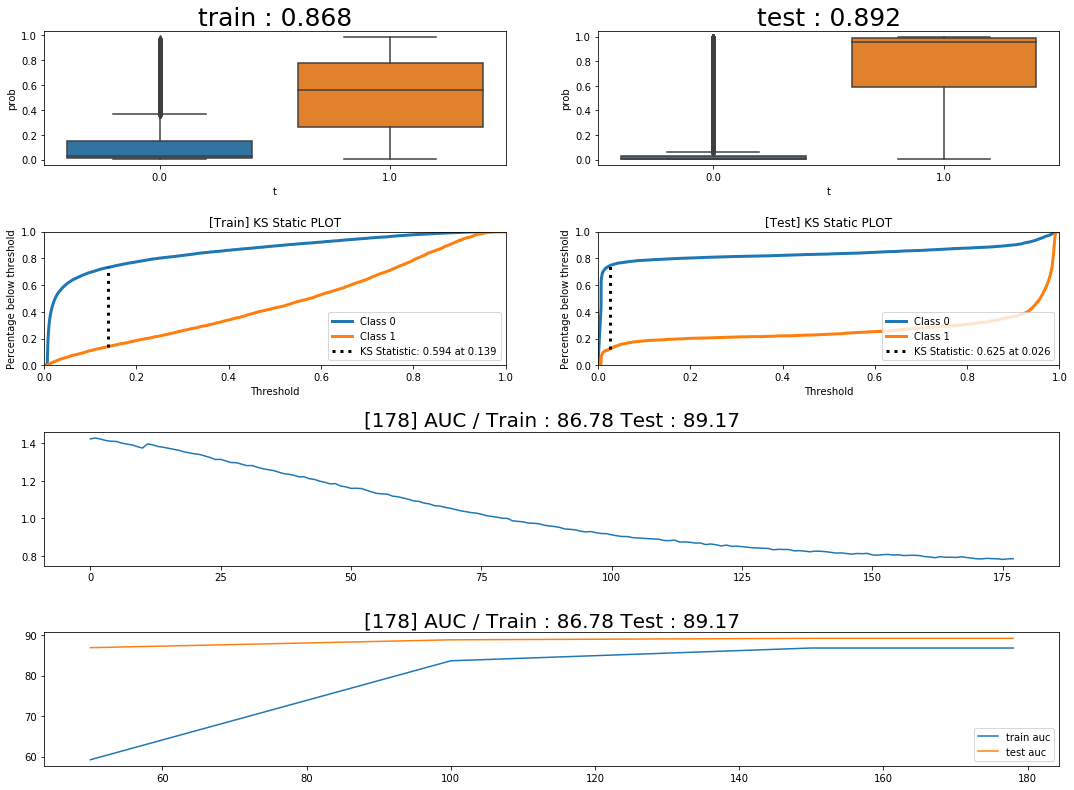

In [136]:
fig , axes = plt.subplots(nrows=4 ,ncols=2,
                  figsize=(15,12) )
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                    top=0.95, wspace=None, hspace=0.3)
ax = axes.flatten()
sns.boxplot(x="t", y="prob", data=trainDD, ax = ax[0])
ax[0].set_title("train : {:.3f}".format(trainAUC), fontsize= 25)
sns.boxplot(x="t", y="prob", data=testDD, ax = ax[1])
ax[1].set_title("test : {:.3f}".format(testAUC), fontsize= 25)
skplt.metrics.plot_ks_statistic(Train_y.values, probs , 
                                ax = ax[2] , 
                                title = "[Train] KS Static PLOT")
skplt.metrics.plot_ks_statistic(Test_y.values, testprobs ,
                                ax = ax[3], 
                                title = "[Test] KS Static PLOT")

ax3 = plt.subplot(413)
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                    top=0.95, wspace=None, hspace=0.5)
ax3.plot(_Epoch_ , _Loss_ )
ax3.set_title(msg, fontsize= 20)
_Epoch2_.append(epoch)
_trAUC_.append(100*trainAUC)
_teAUC_.append(100*testAUC)
ax4 = plt.subplot(414)
ax4.plot(_Epoch2_ , _trAUC_ , label = "train auc")
ax4.plot(_Epoch2_ , _teAUC_ , label = "test auc")
ax4.legend()
msg = "[{}] AUC / Train : {:.2f} Test : {:.2f}".format(epoch , 
                                                       100*trainAUC ,
                                                       100*testAUC
                                                      )
ax4.set_title(msg, fontsize= 20)

In [ ]:
fig , axes = plt.subplots(nrows=3 ,ncols=2,
                          figsize=(20,10) )
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()
DD = pd.DataFrame([real_target ,probs[:,1]],
                          index = ["t","prob"]).T
sns.boxplot(x="t", y="prob", data=DD , ax = ax[0])
ax[0].set_title("train : {:.3f}".format(AUC) , fontsize= 25)
sns.boxplot(x="t", y="prob", data=DD , ax = ax[1])
ax[1].set_title("test : {:.3f}".format(AUC) , fontsize= 25)
skplt.metrics.plot_ks_statistic(Test_y.values[0:100], probs[0:100,:] , 
                                     ax = ax[2] , title = "[Train] KS Static PLOT")
skplt.metrics.plot_ks_statistic(Test_y.values[0:100], probs[0:100,:] , ax = ax[3], 
                                title = "[Test] KS Static PLOT"
                                    )
ax3 = plt.subplot(313)
ax3.plot(np.arange(len(_Loss_)), _Loss_ )
ax3.set_title(msg, fontsize= 20)
plt.show()